In [16]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import io

In [19]:
# Carregando arquivo JSON

with open("dados/sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Inicializa listas
sentences = []
labels = []

# Coletas sentenças e labels
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [20]:
# Deninindo hiperparâmentros 

# Número de exemplos para treino
training_size = 20000

# Tamanho do vocabulários de tokens
vocab_size = 10000

# Comprimento máximo da sequência de palavras
max_length = 32

# Dimensão da camada de Embedding
embedding_dim = 16

In [21]:
# Divisão do dataset em treino e teste
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [22]:
# Parâmentros para padding e OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Inicializa a classe de tokenização
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Gera dicionário word index 
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Cria sentenças de treino e completa o comprimento com pad
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Cria sentenças de teste e completa o comprimento com pad
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Converte os labels em numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [23]:
# Build e compilação do modelo

# Inicializa a camada GlobalAveragePooling1D (GAP1D)
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Define vetor de exemplo
sample_array = np.array([[[10,2],[1,3],[1,1]]])

# Print shape
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# Passa vetor exemplo para pela camada GAP1D
output = gap1d_layer(sample_array)

# Print shape
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


In [24]:
# Build do modelo
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Compila o modelo
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [26]:
num_epochs = 7

# Treina o modelo
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/7
625/625 - 3s - loss: 0.5531 - accuracy: 0.7120 - val_loss: 0.3938 - val_accuracy: 0.8316 - 3s/epoch - 5ms/step
Epoch 2/7
625/625 - 3s - loss: 0.3061 - accuracy: 0.8771 - val_loss: 0.3444 - val_accuracy: 0.8517 - 3s/epoch - 4ms/step
Epoch 3/7
625/625 - 3s - loss: 0.2281 - accuracy: 0.9117 - val_loss: 0.3482 - val_accuracy: 0.8521 - 3s/epoch - 4ms/step
Epoch 4/7
625/625 - 2s - loss: 0.1829 - accuracy: 0.9301 - val_loss: 0.3694 - val_accuracy: 0.8532 - 2s/epoch - 3ms/step
Epoch 5/7
625/625 - 2s - loss: 0.1511 - accuracy: 0.9458 - val_loss: 0.4022 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 6/7
625/625 - 2s - loss: 0.1263 - accuracy: 0.9559 - val_loss: 0.4431 - val_accuracy: 0.8430 - 2s/epoch - 3ms/step
Epoch 7/7
625/625 - 2s - loss: 0.1077 - accuracy: 0.9635 - val_loss: 0.4831 - val_accuracy: 0.8395 - 2s/epoch - 3ms/step


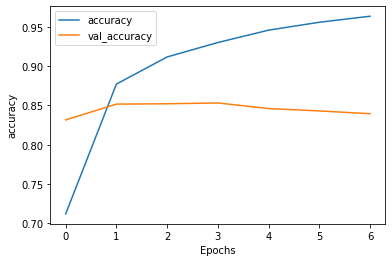

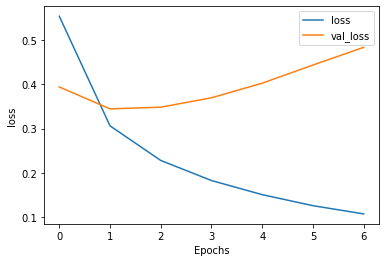

In [27]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
# Plot acurácia
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [28]:
# Coleta dicionário index-word
reverse_word_index = tokenizer.index_word

# Pega dados da camada de embedding (primeira camada)
embedding_layer = model.layers[0]

# Pega os pesos da camada
embedding_weights = embedding_layer.get_weights()[0]

# Print do shape. (vocab_size, embedding_dim)
print(embedding_weights.shape) 

(10000, 16)


In [29]:
# Abre os arquivos
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Inicializa loop. Inicia contagem do `1`, `0` é apenas para o padding
for word_num in range(1, vocab_size):

    # Pega a palavra associada ao index
    word_name = reverse_word_index[word_num]

    # Pega os pesos do embedding associado a cada index
    word_embedding = embedding_weights[word_num]

    # Escreve a palavra associada ao index
    out_m.write(word_name + "\n")

    # Escreve a word embedding
    out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Fecha arquivos
out_v.close()
out_m.close()